In [1]:
import pandas as pd
import numpy as np
import re
import pylab as plt
import copy
import math

ReadStataDct code from Think Stats, as exercise in chapter 13, examined survival curve of divorce in marriage from a different cycle of NSFG survey

In [2]:
def ReadStataDct(dct_file,filename):
    """Reads a Stata dictionary file.

    dct_file: string filename
    options: dict of options passed to open()

    returns: FixedWidthVariables object
    
    FROM Think Stats (A. Downey)
    """
    type_map = dict(byte=int, int=int, long=int, float=float, double=float)

    var_info = []
    for line in open(dct_file):
        match = re.search( r'_column\(([^)]*)\)', line)
        if match:
            start = int(match.group(1))
            t = line.split()
            vtype, name, fstring = t[1:4]
            name = name.lower()
            if vtype.startswith('str'):
                vtype = str
            else:
                vtype = type_map[vtype]
            long_desc = ' '.join(t[4:]).strip('"')
            var_info.append((start, vtype, name, fstring, long_desc))
            
    columns = ['start', 'type', 'name', 'fstring', 'desc']
    variables = pd.DataFrame(var_info, columns=columns)

    # fill in the end column by shifting the start column
    variables['end'] = variables.start.shift(-1)
    variables.loc[len(variables)-1, 'end'] = 0

    #dct = FixedWidthVariables(variables, index_base=1)
    colspecs = variables[['start', 'end']] - 1
    colspecs = colspecs.astype(np.int).values.tolist()
    names = variables['name']
    df = pd.read_fwf(filename,colspecs=colspecs,names=names)
    return df

Using 2006-2010 as it has the largest number of responses

In [3]:
df=ReadStataDct('2006_2010_FemRespSetup.dct','2006_2010_FemResp.dat')

In [4]:
df.describe()

,caseid,rscrninf,rscrage,rscrhisp,rscrrace,age_a,age_r,cmbirth,agescrn,marstat,...,secu,sest,cmintvw,cmlstyr,cmjan3yr,cmjan5yr,questyear,quarter,phase,intvlngth
count,12279.000000,12279.000000,12279.000000,12279.000000,12279.000000,12279.000000,12279.000000,12279.000000,12279.000000,12279.000000,...,12279.000000,12279.000000,12279.000000,12279.000000,12279.000000,12279.000000,12279.000000,12279.000000,12279.000000,12279.000000
mean,33128.309309,2.798844,28.583598,4.155632,4.703722,28.635068,28.635068,953.114179,28.599479,3.736705,...,2.003991,135.988924,1302.753644,1290.753644,1261.509162,1237.509162,2.535386,8.668377,1.084046,81.455548
std,4679.506229,1.989939,8.410234,1.632401,1.039618,8.445265,8.445265,102.338992,8.444188,2.275133,...,1.031860,14.482793,14.213140,14.213140,15.062623,15.062623,1.128579,4.706620,0.277468,100.251288
min,26141.000000,1.000000,15.000000,1.000000,1.000000,15.000000,15.000000,740.000000,15.000000,1.000000,...,1.000000,101.000000,1278.000000,1266.000000,1237.000000,1213.000000,1.000000,1.000000,1.000000,15.600000
25%,29210.500000,1.000000,21.000000,5.000000,4.000000,21.000000,21.000000,869.000000,21.000000,1.000000,...,1.000000,126.000000,1290.000000,1278.000000,1249.000000,1225.000000,1.000000,4.000000,1.000000,52.940000
50%,32280.000000,1.000000,28.000000,5.000000,5.000000,28.000000,28.000000,959.000000,28.000000,4.000000,...,2.000000,140.000000,1303.000000,1291.000000,1261.000000,1237.000000,3.000000,9.000000,1.000000,68.350000
75%,36917.500000,5.000000,36.000000,5.000000,5.000000,36.000000,36.000000,1040.000000,36.000000,6.000000,...,3.000000,148.000000,1315.000000,1303.000000,1273.000000,1249.000000,4.000000,13.000000,1.000000,86.480000
max,42681.000000,5.000000,44.000000,5.000000,6.000000,45.000000,45.000000,1143.000000,44.000000,6.000000,...,4.000000,156.000000,1326.000000,1314.000000,1285.000000,1261.000000,4.000000,16.000000,2.000000,997.000000


Many columns, description for all in codebook https://www.icpsr.umich.edu/webdocs/Controller?displayPage=femaleResp

In [5]:
df.columns

Index([u'caseid', u'rscrninf', u'rscrage', u'rscrhisp', u'rscrrace', u'age_a',
       u'age_r', u'cmbirth', u'agescrn', u'marstat',
       ...
       u'secu', u'sest', u'cmintvw', u'cmlstyr', u'cmjan3yr', u'cmjan5yr',
       u'questyear', u'quarter', u'phase', u'intvlngth'],
      dtype='object', length=3741)

To get started, can get the number of marriages that are known to have ended in divorce (or annulment) divided by all marriages. This will only serve as a lower limit as marriages that were on going at the time of participation in the study may later have ended in divorce. (Note, as certain demographics were oversampled in this study, weights are used.)

In [25]:
def drll(df):
    totM = 0
    totD = 0
    lenM = 0
    lenD = 0
    for i in range(6):
        if i == 0:
            tmpD = df[(df['marendhx'] == 2) | (df['marendhx'] == 3)].wgtq1q16
            tmpM = df[df['whmarhx_y']>0].wgtq1q16
        else:
            tmpD = df[(df['marendhx'+str(i+1)] == 2) | (df['marendhx'+str(i+1)] == 3)].wgtq1q16
            tmpM = df[df['whmarhx_y'+str(i+1)]>0].wgtq1q16
        
        numD = float(len(tmpD))
        numM = float(len(tmpM))
        print ('Frac of marriage '+str(i+1)+' that end in divorce: '+str(tmpD.sum()/tmpM.sum())+' +/- '+str(math.sqrt(numD/numM**2+numD**2/numM**3)))
        totM += tmpM.sum()
        totD += tmpD.sum()
        lenM += float(len(tmpM))
        lenD += float(len(tmpD))
    print ('')
    print ('Total frac of marriages that are known to end in divorce: '+str(totD/totM)+' +/- '+str(math.sqrt(lenD/lenM**2+lenD**2/lenM**3)))

Errors are assuming Poisson noise

In [26]:
drll(df)

Frac of marriage 1 that end in divorce: 0.254362599969 +/- 0.00811999792132
Frac of marriage 2 that end in divorce: 0.319994141533 +/- 0.0238387398622
Frac of marriage 3 that end in divorce: 0.282297754714 +/- 0.061230129067
Frac of marriage 4 that end in divorce: 0.697062932856 +/- 0.202398004455
Frac of marriage 5 that end in divorce: 0.855052286992 +/- 0.334664010614
Frac of marriage 6 that end in divorce: 0.0 +/- 0.0

Total frac of marriages that are known to end in divorce: 0.263809324009 +/- 0.00762651439067


Lower limit, at least of 26% +/- 0.7% marriages end in divorce.

Divorce fraction tends to increase with number of previous marriages, and, due to smaller numbers of marriages, has larger errors.

As mentioned, this is a lower limit. Can get more information by examining lengths of marriages, both those that are known to have ended in divorce and those that are still on going (at the time of being interviewed).

In [32]:
def addMYdate_len(df):
    df['intvMY'] = (df.cmintvw - 1278.0)/12.0 + 2006.5
    df['cmarMY'] = (df.cmmarrch - 1278.0)/12.0 + 2006.5
    
    # for on going marriages, get length of marriage, so far, at time of interview
    df['sofarLen'] = df.intvMY - df.cmarMY
    tmpLen = df.sofarLen
    tmpLen[tmpLen < 0] = 0
    
    for i in range(6):
        if i > 0:
            col_name = ['whmarhx_y'+str(i+1),'whmarhx_m'+str(i+1),'divdathx_y'+str(i+1),'divdathx_m'+str(i+1)]
        else:
            col_name = ['whmarhx_y','whmarhx_m','divdathx_y','divdathx_m']
        tmp_month = copy.deepcopy(df[col_name[1]])
        
        # some months are encoded as > 12. 13, 14, 15, and 16 mean winter, fall, spring, and summer
        # I take the middle month then as the month (will introduce some error)
        # 98 and 99 means refused to answer or did not know, I take middle of year as guess
        # once again this will introduce some error for those few affected
        tmp_month[tmp_month == 13] = 1.0
        tmp_month[tmp_month == 14] = 4.0
        tmp_month[tmp_month == 15] = 7.0
        tmp_month[tmp_month == 16] = 10.0
        tmp_month[(tmp_month == 98) | (tmp_month == 99)] = 6.0
        df['marMY'+str(i+1)] = df[col_name[0]] + tmp_month/12.0
        
        tmp_month = copy.deepcopy(df[col_name[3]])
        tmp_month[tmp_month == 13] = 1.0
        tmp_month[tmp_month == 14] = 4.0
        tmp_month[tmp_month == 15] = 7.0
        tmp_month[tmp_month == 16] = 10.0
        tmp_month[(tmp_month == 98) | (tmp_month == 99)] = 6.0
        df['divMY'+str(i+1)] = df[col_name[2]] + tmp_month/12.0
        
        # due to some of my guessing on month, the resulting marriage length
        # calculated will be < 0 if people got married and divorced (or annuled)
        # within the same year (or got the year wrong)
        # and when people do not know the year or refuse to answer, it gets coded
        # as 98 and 99, resutling in large, positive, or negative marriage lengths
        # for the few affected, I force marriage length to be 0 (ie married and divorced the same year)
        tmp_marLen = df['divMY'+str(i+1)] - df['marMY'+str(i+1)]
        tmp_marLen[(tmp_marLen < 0) | (tmp_marLen > 1e2)] = 0
        df['marLen'+str(i+1)] = tmp_marLen

addMYdate_len(df)

/anaconda3/envs/condasc/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [33]:
df[['sofarLen','marLen1','marLen2','marLen3','marLen4','marLen5','marLen6']].describe()

,sofarLen,marLen1,marLen2,marLen3,marLen4,marLen5,marLen6
count,5537.000000,1574.000000,240.000000,38.000000,5.000000,2.000000,0.0
mean,9.214406,6.231364,4.901042,3.517544,4.666667,0.125000,NaN
std,6.257933,4.565395,4.108876,2.605950,4.396969,0.176777,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,3.916667,2.833333,1.750000,1.479167,1.666667,0.062500,NaN
50%,8.250000,5.250000,4.208333,3.166667,3.000000,0.125000,NaN
75%,13.500000,8.583333,6.625000,4.708333,9.000000,0.187500,NaN
max,29.250000,27.000000,21.250000,10.333333,9.666667,0.250000,NaN


Once again, general trend of marriage length before divorce decreasing with increased marriage #. And while many marriages that are known to end in divorce are over within 9 years (~mean length of on going marriages), first and second marriages that are known to end in divorce have similar max lenghts to current, on going marriages.

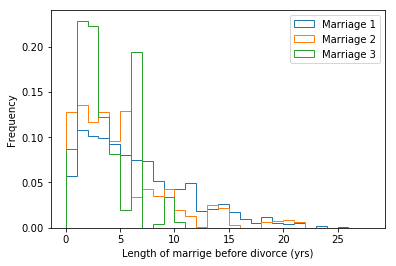

In [40]:
bins = range(int(np.nanmax(df.marLen1.dropna())+2))
for i in range(3):
    plt.hist(df['marLen'+str(i+1)].dropna(),weights=df[df['marLen'+str(i+1)]>=0].wgtq1q16,normed=1,bins=bins,
             label='Marriage '+str(i+1),histtype='step')
plt.xlabel('Length of marrige before divorce (yrs)')
plt.ylabel('Frequency')
plt.legend()

In [44]:
# from now on, treat all divorces the same
# let's get length of marriages, that end in divorce and are on going, into two arrays
def divMarArray(df):
    all_mlen = np.array(df.marLen1.dropna())
    all_mwei = np.array(df[df.marLen1>=0].wgtq1q16)
    for i in range(5):
        tmp_array = np.array(df['marLen'+str(i+2)].dropna())
        all_mlen = np.append(all_mlen,tmp_array)
        tmp_array = np.array(df[df['marLen'+str(i+2)]>=0].wgtq1q16)
        all_mwei = np.append(all_mwei,tmp_array)
    
    sf_len = np.array(df.sofarLen.dropna())
    sf_wei = np.array(df[df.sofarLen>=0].wgtq1q16)
    return all_mlen, all_mwei, sf_len, sf_wei
mlen, mwei, sflen, sfwei = divMarArray(df)

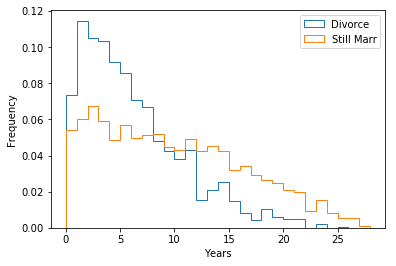

In [45]:
bins = range(int(np.nanmax(mlen)+2))
histD,bins,junk = plt.hist(mlen,bins=bins,histtype='step',label='Divorce',normed=1,weights=mwei)
histM,bins,junk = plt.hist(sflen,bins=bins,histtype='step',label='Still Marr',normed=1,weights=sfwei)
plt.legend()
plt.xlabel('Years')
plt.ylabel('Frequency')

In [49]:
print('Percent divorced within 5 years: '+str(np.sum(mwei[mlen<5.0])/np.sum(mwei)))
print('Percent divorced within 7 years: '+str(np.sum(mwei[mlen<7.0])/np.sum(mwei)))

Percent divorced within 5 years: 0.488210917545
Percent divorced within 7 years: 0.644436966054


The supposed '5 [or 7] year itch', while almost half of all known divorces happen within 5 years, the peak divorce time is between 1 and 2 years of marriage.

In order to calculate the divorce rate (# marriages to end in divorce / # all marriages), we have to consider how to handle current, on going marriages. To estimate the number that will end in divorce, at every marriage length year I do the following:

    1) calculate the yearly divorce rate, D(t) = d(t) / (n(t) - u(t))
        - d(t) = # divorced in that year
        - n(t) = total # of marriages endering that year (whether on going or end in divorce)
        - u(t) = # on going marriages with lenghts equal to t (they could possibly end in divorce at >= t)
    2) set D(t) * u(t) to 'end' in divorce that year, while (1 - D(t)) * u(t) will 'stay married'
        - m(t) = estimated 'still married' from u(t) is added to u(t+1) and n(t+1)
    3) calculate errors (assume Poisson noise)
    
    D(t) is self-consistent with the addition of m(t) to u(t+1) and n(t+1):
    D(t) = [d(t) + u(t) * D(t)] / n(t) = d(t) / (n(t) - u(t))

In [128]:
def estDiv(d_arr,d_wei,sm_arr,sm_wei,dyr=1.0):
    years = np.array(range(int(np.max(d_arr)/dyr + 1.0)))*dyr
    est_d = np.zeros(len(years)-1)
    est_m = np.zeros(len(years)-1)
    esd_len = np.zeros(len(years)-1)
    esm_len = np.zeros(len(years)-1)
    rate_d = np.zeros(len(years)-1)
    div_w = np.zeros(len(years)-1)
    known_d = np.zeros(len(years)-1)
    d_error = np.zeros(len(years)-1)
    
    
    for i in range(len(years)-1):
        dm_tot = float(len(np.where(d_arr >= years[i])[0]) + len(np.where(sm_arr >= years[i])[0]))
        tot_w = np.sum(d_wei[d_arr >= years[i]]) + np.sum(sm_wei[sm_arr >= years[i]])
        
        known_d[i] = float(len(np.where((d_arr >= years[i]) & (d_arr < years[i+1]))[0]))
        div_w[i] = np.sum(d_wei[(d_arr >= years[i]) & (d_arr < years[i+1])])
        
        dm_ukn = float(len(np.where((sm_arr >= years[i]) & (sm_arr < years[i+1]))[0]))
        ukn_w = np.sum(sm_wei[(sm_arr >= years[i]) & (sm_arr < years[i+1])])
        if i > 0:
            dm_ukn += esm_len[i-1]
            dm_tot += esm_len[i-1]
            tot_w += est_m[i-1]
            ukn_w += est_m[i-1]
        
        rate_d[i] = div_w[i] / (tot_w - ukn_w)
        
        est_d[i] = rate_d[i] * ukn_w
        
        est_m[i] = (1.0 - rate_d[i]) * ukn_w
        esm_len[i] = (1.0 - rate_d[i]) * dm_ukn
        
        d_error[i] = known_d[i]**2*dm_tot**2*dm_ukn/(dm_tot - dm_ukn)**4 + dm_ukn**2*known_d[i]/(dm_tot - dm_ukn)**2
        d_error[i] += dm_ukn**2*known_d[i]**2*dm_tot/(dm_tot - dm_ukn)**4

    d_error = np.sqrt(d_error)
    cumu_d = np.array([np.sum(div_w[:i+1])+np.sum(est_d[:i+1]) for i in range(len(est_d))])
    cumu_e = np.array([math.sqrt(np.sum(d_error[:i+1]**2) + np.sum(known_d[:i+1])) for i in range(len(est_d))])
    
    return rate_d,years[1:],cumu_d,d_error,cumu_e, div_w+est_d
rate_d,yrs,cumud,d_error,cumue,tot_d = estDiv(mlen, mwei, sflen, sfwei)

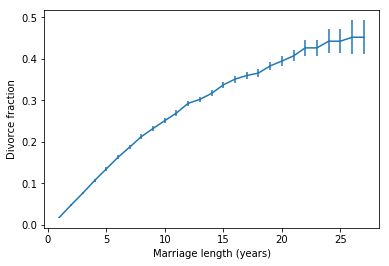

In [129]:
plt.errorbar(yrs,cumud/(np.sum(mwei)+np.sum(sfwei)),yerr=cumue/(len(mwei)+len(sfwei)))
plt.xlabel('Marriage length (years)')
plt.ylabel('Divorce fraction')

In [130]:
for i in range(len(yrs)):
    print('Year '+str(yrs[i])+': divorce frac '+str(round(cumud[i]/(np.sum(mwei)+np.sum(sfwei)),3))+' +/- '
          +str(round(cumue[i]/(len(mwei)+len(sfwei)),3)))

Year 1.0: divorce frac 0.018 +/- 0.002
Year 2.0: divorce frac 0.048 +/- 0.002
Year 3.0: divorce frac 0.076 +/- 0.003
Year 4.0: divorce frac 0.106 +/- 0.004
Year 5.0: divorce frac 0.134 +/- 0.004
Year 6.0: divorce frac 0.162 +/- 0.005
Year 7.0: divorce frac 0.187 +/- 0.005
Year 8.0: divorce frac 0.212 +/- 0.005
Year 9.0: divorce frac 0.232 +/- 0.006
Year 10.0: divorce frac 0.251 +/- 0.006
Year 11.0: divorce frac 0.269 +/- 0.006
Year 12.0: divorce frac 0.293 +/- 0.007
Year 13.0: divorce frac 0.302 +/- 0.007
Year 14.0: divorce frac 0.317 +/- 0.007
Year 15.0: divorce frac 0.337 +/- 0.008
Year 16.0: divorce frac 0.351 +/- 0.008
Year 17.0: divorce frac 0.36 +/- 0.009
Year 18.0: divorce frac 0.366 +/- 0.009
Year 19.0: divorce frac 0.383 +/- 0.01
Year 20.0: divorce frac 0.394 +/- 0.012
Year 21.0: divorce frac 0.407 +/- 0.013
Year 22.0: divorce frac 0.426 +/- 0.019
Year 23.0: divorce frac 0.426 +/- 0.019
Year 24.0: divorce frac 0.442 +/- 0.029
Year 25.0: divorce frac 0.442 +/- 0.029
Year 26.0: 

Divorce rate (after 27 years) 45.2% +/- 4.1%, just under the famed 'half of all marriages'. But, after 21 years, the yearly divorce rate starts bouncing between high values and 0.

I will use the divorce rate at 22 years (consistent with that at 27 years anyway): 40.7% +/- 1.3%

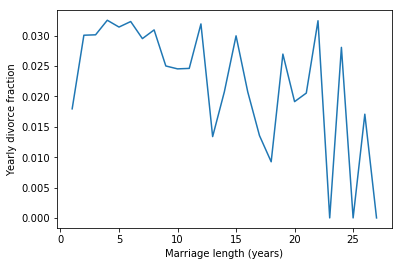

In [131]:
plt.plot(yrs,rate_d)
plt.xlabel('Marriage length (years)')
plt.ylabel('Yearly divorce fraction')

Might be some wisdom in the '5 year itch', years ~2-8 of a marriage have a general peak in yearly divorce fraction (ie the probability that a marriage, entering that year, will end in divorce within that year)

In [132]:
np.argmax(rate_d)+1,np.max(rate_d)

(4, 0.032547578405240293)

What about using 2 year bins, as opposed to 1 year

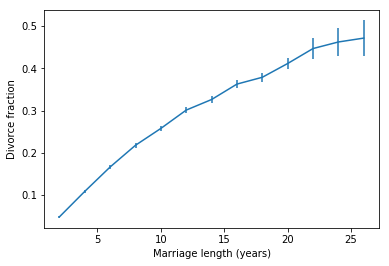

In [133]:
rate_d2,yrs2,cumud2,d_error2,cumue2,tot_d2 = estDiv(mlen, mwei, sflen, sfwei,dyr=2.0)
plt.errorbar(yrs2,cumud2/(np.sum(mwei)+np.sum(sfwei)),yerr=cumue2/(len(mwei)+len(sfwei)))
plt.xlabel('Marriage length (years)')
plt.ylabel('Divorce fraction')

In [135]:
for i in range(len(yrs2)):
    print('Year '+str(yrs2[i])+': divorce frac '+str(round(cumud2[i]/(np.sum(mwei)+np.sum(sfwei)),3))+' +/- '
          +str(round(cumue2[i]/(len(mwei)+len(sfwei)),3)))

Year 2.0: divorce frac 0.048 +/- 0.003
Year 4.0: divorce frac 0.109 +/- 0.004
Year 6.0: divorce frac 0.166 +/- 0.005
Year 8.0: divorce frac 0.218 +/- 0.006
Year 10.0: divorce frac 0.258 +/- 0.006
Year 12.0: divorce frac 0.301 +/- 0.007
Year 14.0: divorce frac 0.326 +/- 0.008
Year 16.0: divorce frac 0.363 +/- 0.009
Year 18.0: divorce frac 0.379 +/- 0.01
Year 20.0: divorce frac 0.412 +/- 0.014
Year 22.0: divorce frac 0.447 +/- 0.024
Year 24.0: divorce frac 0.462 +/- 0.033
Year 26.0: divorce frac 0.472 +/- 0.042


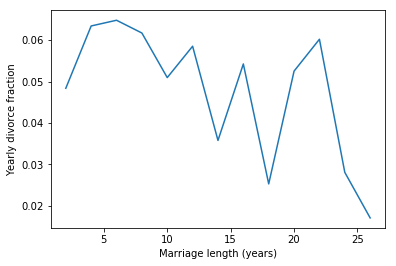

In [136]:
plt.plot(yrs2,rate_d2)
plt.xlabel('Marriage length (years)')
plt.ylabel('Yearly divorce fraction')